Epoch [100/500], Loss: 0.002211
Epoch [200/500], Loss: 0.001370
Epoch [300/500], Loss: 0.001101
Epoch [400/500], Loss: 0.000995
Epoch [500/500], Loss: 0.000909
Test modulation index 0.8 is NOT in the training dataset


([<matplotlib.axis.XTick at 0x74156742e090>,
 [Text(0, 0, '0'),
  Text(50, 0, '50'),
  Text(100, 0, '100'),
  Text(150, 0, '150'),
  Text(200, 0, '200'),
  Text(250, 0, '250'),
  Text(300, 0, '300'),
  Text(350, 0, '350'),
  Text(400, 0, '400'),
  Text(450, 0, '450')])

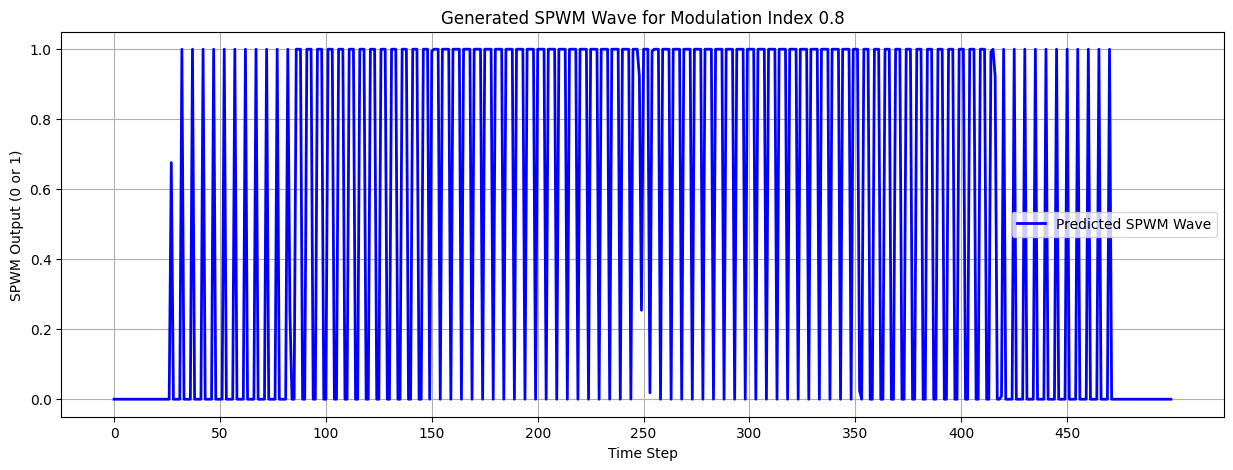

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load Dataset
data = pd.read_csv("spwm_dataset_60kHz.csv", header=None).values

# Split dataset into inputs (modulation index) and outputs (SPWM wave)
modulation_indices = data[:, 0].astype(np.float32)  # First column: modulation index
spwm_waves = data[:, 1:].astype(np.float32)  # Remaining columns: SPWM wave

# Convert to PyTorch tensors
inputs = torch.tensor(modulation_indices).view(-1, 1)  # Reshape for single feature input
targets = torch.tensor(spwm_waves)

# Create Dataset & DataLoader
dataset = TensorDataset(inputs, targets)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define Neural Network
class SPWMNet(nn.Module):
    def __init__(self, output_size):
        super(SPWMNet, self).__init__()
        self.fc1 = nn.Linear(1, 64)  # Input: 1 (modulation index), Hidden: 64
        self.fc2 = nn.Linear(64, 128)  # Hidden layer
        self.fc3 = nn.Linear(128, output_size)  # Output: SPWM waveform

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid activation for binary outputs
        return x

# Define Model
output_size = spwm_waves.shape[1]  # Number of SPWM samples per waveform
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

spwm_model = SPWMNet(output_size).to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for 0s and 1s
optimizer = optim.Adam(spwm_model.parameters(), lr=0.0005)

# Training Function
def train_model(model, dataloader, epochs=1000, lr=0.0005):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            # Ensure data types are correct
            targets = targets.float()
            outputs = model(inputs).float()

            # Compute loss
            loss = criterion(outputs, targets)

            # Debugging: Check if loss requires gradients
            if not loss.requires_grad:
                print("Warning: Loss does not require gradients!")

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        # Print loss every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader):.6f}")

# Train the model
train_model(spwm_model, train_loader, epochs=500, lr=0.0005)

# Convert training modulation indices to a NumPy set for fast lookup
unique_train_indices = set(modulation_indices)  # Unique modulation indices in training set

# Define test modulation index
test_modulation_index = 0.8  # Example test index

# Check if the test modulation index exists in the training dataset
if test_modulation_index in unique_train_indices:
    print(f"Test modulation index {test_modulation_index} is present in the training dataset.")
else:
    print(f"Test modulation index {test_modulation_index} is NOT in the training dataset")

# Test the Model
spwm_model.eval()
test_input = torch.tensor([[0.8]], dtype=torch.float32).to(device)  # Example: Modulation index = 0.8
predicted_wave = spwm_model(test_input).detach().cpu().numpy().flatten()

''' Plot the predicted SPWM wave
plt.figure(figsize=(20, 4))
plt.plot(predicted_wave, label="Predicted SPWM Wave", color='b')
plt.xlabel("Time Step")
plt.ylabel("SPWM Output (0 or 1)")
plt.title("Generated SPWM Wave for Modulation Index 0.8")
plt.legend()
plt.grid()
plt.show() '''

# Plot the predicted SPWM wave (showing only 500 time steps)
time_steps = 500  # Number of points to display

plt.figure(figsize=(15, 5))  # Increase width (15 inches) while keeping height reasonable (5 inches)
plt.plot(range(time_steps), predicted_wave[:time_steps], label="Predicted SPWM Wave", color='b', linewidth=2)

plt.xlabel("Time Step")
plt.ylabel("SPWM Output (0 or 1)")
plt.title("Generated SPWM Wave for Modulation Index 0.8")  
plt.legend()
plt.grid(True)

# Adjust x-axis ticks for better spacing
plt.xticks(np.arange(0, time_steps, step=50))  # Show ticks every 50 time steps